In [97]:
# import libraries
import math
from scipy.stats import norm
from math import log, ceil, exp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# evaluate g
def evaluate_g(u, d, r, sigma, delta_t):
    """
    Evaluate the function g(u, d) for given parameters.
    """
    g = np.zeros(2)
    g[0] = ((r - 0.5 * sigma**2) * delta_t * (u - d) - 
            ((np.exp(r * delta_t) - d) * np.log(u) + (u - np.exp(r * delta_t)) * np.log(d)))
    log_ratio = np.log(u) - np.log(d)
    g[1] = (sigma**2 * delta_t * (u - d)**2 - 
            (np.exp(r * delta_t) - d) * (u - np.exp(r * delta_t)) * log_ratio**2)
    return g

In [3]:
# calculate jacobian
def jacobian_g(u, d, r, sigma, delta_t):
    """
    Calculate the Jacobian matrix of g(u, d) for given parameters.
    """
    J = np.zeros((2, 2))
    J[0, 0] = (r - 0.5 * sigma**2) * delta_t - (np.exp(r * delta_t) - d) / u - np.log(d)
    J[0, 1] = -(r - 0.5 * sigma**2) * delta_t + np.log(u) - (u - np.exp(r * delta_t)) / d
    log_ratio = np.log(u / d)
    J[1, 0] = (2 * sigma**2 * delta_t * (u - d) - 
               (np.exp(r * delta_t) - d) * ((u - np.exp(r * delta_t)) * (2 / u) * log_ratio + log_ratio**2))
    J[1, 1] = (-2 * sigma**2 * delta_t * (u - d) + 
               (u - np.exp(r * delta_t)) * ((np.exp(r * delta_t) - d) * (2 / d) * log_ratio + log_ratio**2))
    return J

In [4]:
# define newtons method
def newtons_method(r, sigma, delta_t, u0=None, d0=None, tol=1e-8, max_iter=500):
    """
    Apply Newton's method to solve g(u, d) = 0 and track convergence history.
    """
    u0 = np.exp(sigma * np.sqrt(delta_t)) if u0 is None else u0
    d0 = np.exp(-sigma * np.sqrt(delta_t)) if d0 is None else d0
    
    x = np.array([u0, d0], dtype=float)
    u_history = [u0]
    d_history = [d0]
    
    for i in range(max_iter):
        g = evaluate_g(x[0], x[1], r, sigma, delta_t)
        J = jacobian_g(x[0], x[1], r, sigma, delta_t)
        
        if np.linalg.norm(g) < tol:
            return x[0], x[1], True, i, u_history, d_history
        
        try:
            delta_x = np.linalg.solve(J, -g)
        except np.linalg.LinAlgError:
            print(f"Warning: Singular Jacobian at r={r:.3f}, sigma={sigma:.3f}, returning initial values")
            return x[0], x[1], False, i, u_history, d_history
        
        x += delta_x
        u_history.append(x[0])
        d_history.append(x[1])
        
        if x[0] <= 0 or x[1] <= 0:
            print(f"Warning: Negative u or d at r={r:.3f}, sigma={sigma:.3f}, returning current values")
            return x[0], x[1], False, i, u_history, d_history
    
    print(f"Warning: Max iterations reached at r={r:.3f}, sigma={sigma:.3f}")
    return x[0], x[1], False, max_iter, u_history, d_history

In [5]:
# define plot_convergence function
def plot_convergence(r=0.05, sigma=0.2, delta_t=1/12, tol=1e-10, max_iter=500):
    """
    Plot the convergence of u and d during Newton's method iterations.
    """
    # Run Newton's method
    u, d, converged, iters, u_history, d_history = newtons_method(r, sigma, delta_t, tol=tol, max_iter=max_iter)
    
    # Create iteration indices for plotting
    iterations = range(len(u_history))
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Plot u convergence
    plt.subplot(2, 1, 1)
    plt.plot(iterations, u_history, 'o-', label='u values', color='#1f77b4')
    if converged:
        plt.axhline(y=u, color='r', linestyle='--', label=f'Converged u = {u:.6f}')
    plt.xlabel('Iteration')
    plt.ylabel('u')
    plt.title('Convergence of Up Factor (u)')
    plt.legend()
    plt.grid(True)
    
    # Plot d convergence
    plt.subplot(2, 1, 2)
    plt.plot(iterations, d_history, 'o-', label='d values', color='#ff7f0e')
    if converged:
        plt.axhline(y=d, color='r', linestyle='--', label=f'Converged d = {d:.6f}')
    plt.xlabel('Iteration')
    plt.ylabel('d')
    plt.title('Convergence of Down Factor (d)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print convergence status
    print(f"Converged: {converged}")
    print(f"Iterations: {iters}")
    print(f"Final u: {u:.6f}")
    print(f"Final d: {d:.6f}")

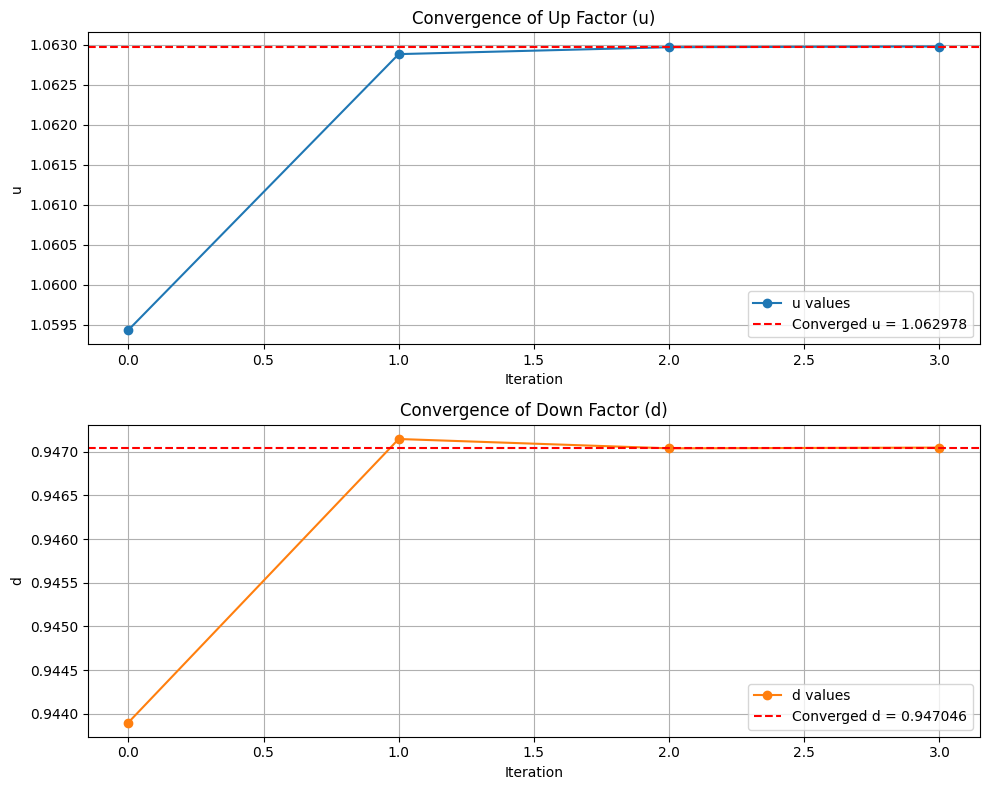

Converged: True
Iterations: 3
Final u: 1.062978
Final d: 0.947046


In [6]:
plot_convergence(r=0.05, sigma=0.2, delta_t=1/12)

In [7]:
# define deviation heatmap function
def plot_deviation_heatmap(delta_t, r_low, r_high, s_low, s_high):
    r_values = np.linspace(r_low, r_high, 20)
    sigma_values = np.linspace(s_low, s_high, 20)
    
    u_error = np.zeros((len(sigma_values), len(r_values)))
    d_error = np.zeros((len(sigma_values), len(r_values)))
    
    for i, sigma in enumerate(sigma_values):
        for j, r in enumerate(r_values):
            u0_crr = np.exp(sigma * np.sqrt(delta_t))
            d0_crr = np.exp(-sigma * np.sqrt(delta_t))
            
            try:
                u, d, converged, _, _, _ = newtons_method(r, sigma, delta_t)
                if not converged or u <= 0 or d <= 0 or u0_crr <= 0 or d0_crr <= 0:
                    u_error[i, j] = np.nan
                    d_error[i, j] = np.nan
                else:
                    u_error[i, j] = abs((u - u0_crr) / u0_crr) * 100
                    d_error[i, j] = abs((d - d0_crr) / d0_crr) * 100
            except Exception as e:
                print(f"Error at r={r:.3f}, sigma={sigma:.3f}: {e}")
                u_error[i, j] = np.nan
                d_error[i, j] = np.nan
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(u_error, aspect='auto', cmap='viridis', extent=[r_values.min(), r_values.max(), sigma_values.max(), sigma_values.min()], vmin=0, vmax=1)
    plt.colorbar(label='% Deviation in u')
    plt.xlabel('Risk-Free Rate (r)')
    plt.ylabel('Volatility (σ)')
    plt.title('Percentage Deviation in u (Converged Only)')
    
    plt.subplot(1, 2, 2)
    plt.imshow(d_error, aspect='auto', cmap='viridis', extent=[r_values.min(), r_values.max(), sigma_values.max(), sigma_values.min()], vmin=0, vmax=1)
    plt.colorbar(label='% Deviation in d')
    plt.xlabel('Risk-Free Rate (r)')
    plt.ylabel('Volatility (σ)')
    plt.title('Percentage Deviation in d (Converged Only)')
    
    plt.tight_layout()
    plt.show()

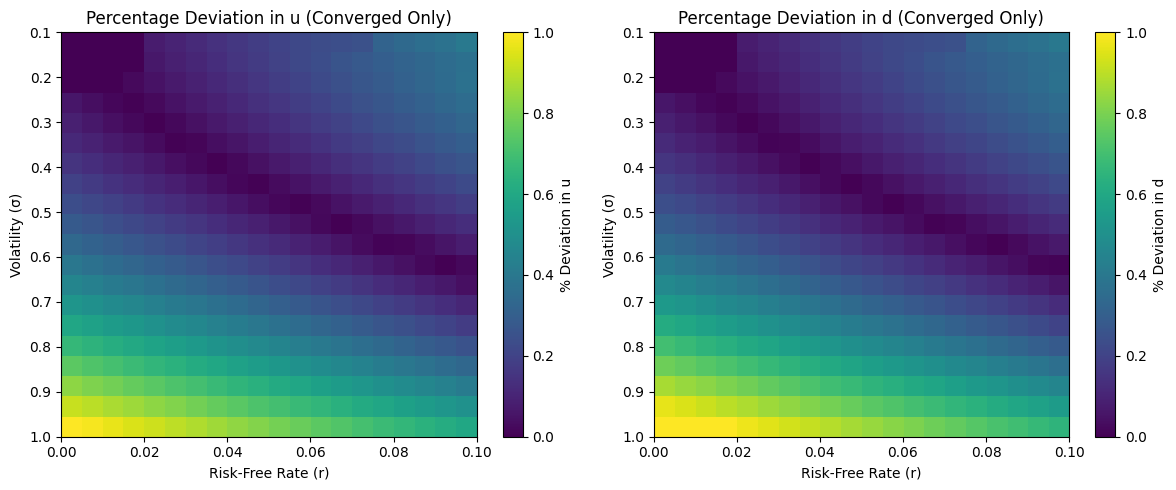

In [8]:
plot_deviation_heatmap(1/24, 0, 0.1, 0.1, 1.0)

In [9]:
# plot % deviation agains timestep duration
def plot_deviation_vs_deltat(r=0.05, sigma=0.2, delta_t_range=np.linspace(1/252, 1/12, 20), tol=1e-10, max_iter=500):
    """
    Plot the percentage deviation between CRR estimates and converged u, d values vs delta_t.
    
    Parameters:
    r (float): Risk-free rate
    sigma (float): Volatility
    delta_t_range (array): Range of delta_t values to test
    tol (float): Tolerance for convergence
    max_iter (int): Maximum number of iterations
    """
    u_deviation = []
    d_deviation = []
    converged_flags = []
    
    for delta_t in delta_t_range:
        # CRR initial estimates
        u0_crr = np.exp(sigma * np.sqrt(delta_t))
        d0_crr = np.exp(-sigma * np.sqrt(delta_t))
        
        # Run Newton's method
        u, d, converged, _, _, _ = newtons_method(r, sigma, delta_t, tol=tol, max_iter=max_iter)
        
        # Store convergence status
        converged_flags.append(converged)
        
        # Calculate percentage deviation only if converged and values are valid
        if converged and u > 0 and d > 0 and u0_crr > 0 and d0_crr > 0:
            u_dev = abs((u - u0_crr) / u0_crr) * 100
            d_dev = abs((d - d0_crr) / d0_crr) * 100
        else:
            u_dev = np.nan
            d_dev = np.nan
        
        u_deviation.append(u_dev)
        d_deviation.append(d_dev)
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    
    # Plot u deviation
    plt.plot(delta_t_range, u_deviation, 'o-', label='% Deviation in u', color='#1f77b4')
    for i, converged in enumerate(converged_flags):
        if not converged:
            plt.plot(delta_t_range[i], u_deviation[i], 'rx', markersize=10, label='Non-converged' if i == 0 else "")
    plt.xlabel('Delta t (years)')
    plt.ylabel('% Deviation')
    plt.title('Percentage Deviation of u from CRR Estimate vs Delta t')
    plt.legend()
    plt.grid(True)

    # calculate LoBF for u
    valid_delta_t = delta_t_range[~np.isnan(u_deviation)]
    valid_u_dev = [x for x in u_deviation if not np.isnan(x)]
    if len(valid_delta_t) > 1:  # Ensure enough points for fitting
        coefficients = np.polyfit(valid_delta_t, valid_u_dev, 1)  # Linear fit (degree 1)
        polynomial = np.poly1d(coefficients)
        equation = f'y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}'
        plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.8))
    
    # Plot d deviation (secondary y-axis for clarity)
    plt.subplot()
    plt.plot(delta_t_range, d_deviation, 'o-', label='% Deviation in d', color='#ff7f0e')
    for i, converged in enumerate(converged_flags):
        if not converged:
            plt.plot(delta_t_range[i], d_deviation[i], 'rx', markersize=10)
    plt.ylabel('% Deviation')
    plt.title('Percentage Deviation of u and d from CRR Estimate vs Delta t, r=0.05, sigma=0.2')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Tested delta_t range: {delta_t_range[0]:.4f} to {delta_t_range[-1]:.4f}")
    print(f"Number of non-converged cases: {sum(1 for c in converged_flags if not c)}")

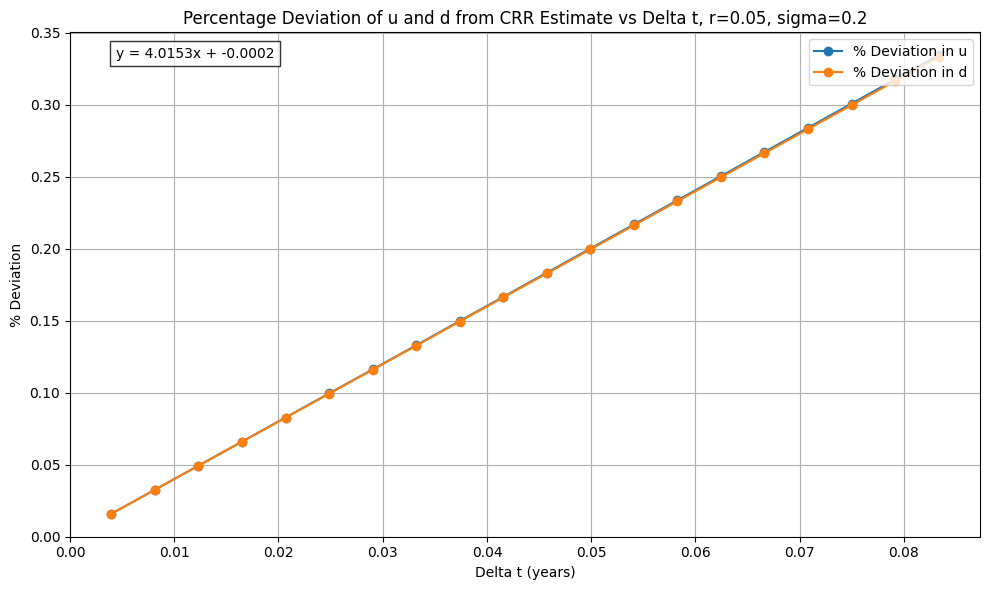

Tested delta_t range: 0.0040 to 0.0833
Number of non-converged cases: 0


In [10]:
plot_deviation_vs_deltat()

In [83]:
def european_call_option_theo_BOPM(time_to_exp, strike, initial_price, vol, r, n):
    delta_t = time_to_exp/n
    R = math.exp(r * delta_t)

    u, d, converged, _, _, _ = newtons_method(r, vol, delta_t)

    log_u_d = math.log(u) - math.log(d)
    p = (R - d)/(u - d)

    theo = 0
    for k in range(0, n + 1):
        theo += math.comb(n, k) * p**(k) * (1 - p)**(k) * (max(initial_price * u**(k) * d **(n-k) - strike, 0))

    theo *= R**(-n)
    return theo

In [84]:
print(european_call_option_theo_BOPM(1.03, 6500, 6495.15, 0.16, 0.0365, 252))

2.715378000761766


In [110]:
def european_call_option_theo_BOPM_optimised(time_to_exp, strike, initial_price, vol, r, n):
    delta_t = time_to_exp / n
    discount = exp(-r * time_to_exp)

    u, d, converged, _, _, _ = newtons_method(r, vol, delta_t)
    R = math.exp(r * delta_t)
    p = (R - d) / (u - d)

    theo = 0
    for k in range(0, n + 1):
        log_stock_price = log(initial_price) + k * log(u) + (n - k) * log(d)

        log_binom = math.lgamma(n + 1) - math.lgamma(k + 1) - math.lgamma(n - k + 1)

        log_prob = log_binom + k * log(p) + (n - k) * log(1 - p)

        payoff = max(exp(log_stock_price) - strike, 0)

        prob = exp(log_prob)
        theo += prob * payoff

    theo *= discount
    return theo

In [111]:
print(european_call_option_theo_BOPM_optimised(1.03, 6500, 6495.15, 0.16, 0.0365, 252))

540.4375008351406


In [102]:
def black_scholes_call(time_to_exp, strike, initial_price, vol, r, ):
    # Calculate d1 and d2
    d1 = (math.log(initial_price / strike) + (r + 0.5 * vol**2) * time_to_exp) / (vol * math.sqrt(time_to_exp))
    d2 = d1 - vol * math.sqrt(time_to_exp)
    
    # Black-Scholes call option price
    call_price = initial_price * norm.cdf(d1) - strike * math.exp(-r * time_to_exp) * norm.cdf(d2)
    
    return call_price

In [103]:
print(black_scholes_call(1.03, 6500, 6495.15, 0.16, 0.0365))

540.7450172868471


In [148]:
def plot_convergence_BOPM_BS():
    # Parameters
    T = 0.01
    K = 6500
    S = 6500
    vol = 0.9597
    r = 0.035
    n_values = [20, 30, 40, 50, 100, 200, 500, 1000, 2000]
    
    # Compute BOPM prices (assuming european_call_option_theo_BOPM_optimised is defined)
    bopm_prices = [european_call_option_theo_BOPM_optimised(T, K, S, vol, r, n) for n in n_values]
    
    # Compute Black-Scholes price
    d1 = (math.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * math.sqrt(T))
    d2 = d1 - vol * math.sqrt(T)
    bs_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    
    # Plotting
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, bopm_prices, 'b-o', label='BOPM Price')
    plt.axhline(y=bs_price, color='r', linestyle='--', label=f'Black-Scholes Price ({bs_price:.2f})')
    plt.xlabel('Number of Steps (n)')
    plt.ylabel('Call Option Price')
    plt.title('Convergence of BOPM to Black-Scholes')
    plt.legend()
    plt.grid(True)
    plt.show()

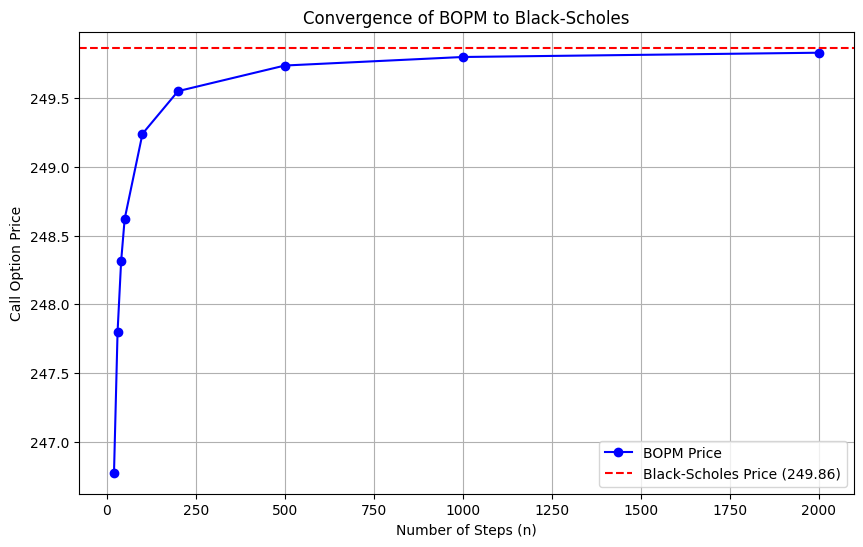

In [149]:
plot_convergence_BOPM_BS()